<a href="https://colab.research.google.com/github/AlexTako/AI_practice/blob/main/AI_staff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai gradio tiktoken langchain langchain-openai langchain-community chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.3 MB/s 

In [ ]:
import getpass # для работы с паролями
import os      # для работы с окружением и файловой системой

# Запрос ввода ключа от OpenAI
os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите OpenAI API Key:")

Введите OpenAI API Key:··········


In [ ]:
models = [
              {
                "doc": "https://docs.google.com/document/d/1ySwSV1r6MpbamK_j1WS2VLapGi8BgYICLvYWrHNtTmY/edit",
                "prompt": '''Ты писатель научных статей, к тебе могут обращаться  молодые писатели и оыптные люди для свежей информации.
                        Постарайся дать развернутый ответ, твоя задача ответить так, чтобы у писателя не осталось больше вопросов к тебе.
                        Отвечай по существу, без лишних эмоций и слов, от тебя нужна только точная информация.
                        Отвечай максимально точно по документу, не придумывай ничего от себя.
                        Документ с информацией для ответа клиенту: ''',
                "name": "Нейро-менеджер поддержки писателей",
                "query": "Как написать научную статью?"
              },
              {
                "doc": "https://docs.google.com/document/d/1oy8eaTyQ5Y6dK12nSy6yqZhdj_7lrGq70XVB2L3Lw20/edit",
                "prompt": '''Ты специалист по маркетингу. Перед тобой документ, в котором описаны способы монетизации написанных статей.
                        Твоя задача объяснить тому кто к тебе обращается, как заработать деньги на написании статей.
                        Документ: ''',
                "name": "Нейро-маркетолог",
                "query": "Как заработать на написании статей?"
              }
            ]

In [ ]:
# Блок библиотек фреймворка LangChain

# Работа с документами в langchain
from langchain.docstore.document import Document
# Эмбеддинги для OpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
# Доступ к векторной базе данных
from langchain.vectorstores import Chroma
# Разделение текста на куски или чанки (chunk)
from langchain.text_splitter import CharacterTextSplitter

# Отправка запросов
import requests

#Доступ к OpenAI
from openai import OpenAI

# Отприсовка интерфейса с помощью grad
import gradio as gr

# Библиотека подсчёта токенов
# Без запроcов к OpenAI, тем самым не тратим деньги на запросы
import tiktoken

# Для работы с регулярными выражениями
import re

In [ ]:
# Объявляем класс нейро-сотрудника
class GPT():
    # Объявляем конструктор класса, для передачи имени модели и инициализации атрибутов класса
    def __init__(self, model="gpt-3.5-turbo"):
        self.log = ''               # атрибут для сбора логов (сообщений)
        self.model = model          # атрибут для хранения выбранной модели OpenAI
        self.search_index = None    # атрибут для хранения ссылки на базу знаний (если None, то модель не обучена)
        self.client = OpenAI(api_key=os.environ["OPENAI_API_KEY"]) # при инициализации запрашиваем ключ от OpenAI

    # Метод загрузки текстового документа в векторную базу знаний
    def load_search_indexes(self, url):
        # Извлекаем document ID гугл документа из URL с помощью регулярных выражений
        match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)

        # Если ID не найден - генерируем исключение
        if match_ is None:
            raise ValueError('Неверный Google Docs URL')

        # Первый элемент в результате поиска
        doc_id = match_.group(1)

        # Скачиваем гугл документ по его ID в текстовом формате
        response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')

        # При неудачных статусах запроса будет вызвано исключение
        response.raise_for_status()

        # Извлекаем данные как текст
        text = response.text

        # Вызываем метод векторизации текста и сохранения в векторную базу данных
        return self.create_embedding(text)

    # Подсчет числа токенов в строке по имени модели
    def num_tokens_from_string(self, string):
            """Возвращает число токенов в строке"""
            encoding = tiktoken.encoding_for_model(self.model)  # получаем кодировщик по имени модели
            num_tokens = len(encoding.encode(string))           # расчитываем строку с помощью кодировщика
            return num_tokens                                   # возвращаем число токенов

    # Метод разбора текста и его сохранение в векторную базу знаний
    def create_embedding(self, data):
        # Список документов, полученных из фрагментов текста
        source_chunks = []
        # Разделяем текст на строки по \n (перенос на новую строку) или длине фрагмента (chunk_size=1024) с помощью сплитера
        # chunk_overlap=0 - означает, что фрагменты не перекрываются друг с другом.
        # Если больше нуля, то захватываем дополнительное число символов от соседних чанков.
        splitter = CharacterTextSplitter(separator="\n", chunk_size=1024, chunk_overlap=0)

        # Применяем splitter (функцию расщепления) к данным и перебираем все получившиеся чанки (фрагменты)
        for chunk in splitter.split_text(data):
            # LangChain работает с документами, поэтому из текстовых чанков мы создаем фрагменты документов
            source_chunks.append(Document(page_content=chunk, metadata={}))

        # Подсчет числа токенов в документах без запроса к OpenAI (экономим денежные средства)
        count_token = self.num_tokens_from_string(' '.join([x.page_content for x in source_chunks]))
        # Вместо вывода print, мы формируем переменную log для дальнейшего вывода в gradio информации
        self.log += f'Количество токенов в документе : {count_token}\n'

        # Создание индексов документа. Применяем к нашему списку документов эмбеддингов OpenAi и в таком виде загружаем в базу ChromaDB
        self.search_index = Chroma.from_documents(source_chunks, OpenAIEmbeddings(), )
        # Вместо вывода print, мы формируем переменную log для дальнейшего вывода в gradio информации
        self.log += f'Данные из документа загружены в в векторную базу данных\n'

        # Возвращаем ссылку на базу данных
        return self.search_index

    # Демонстрация более аккуратного расчета числа токенов в зависимости от модели
    def num_tokens_from_messages(self, messages, model):
        """Возвращает число токенов из списка сообщений"""
        try:
            encoding = tiktoken.encoding_for_model(model) # получаем кодировщик по имени модели
        except KeyError:
            print("Предупреждение: модель не создана. Используйте cl100k_base кодировку.")
            encoding = tiktoken.get_encoding("cl100k_base") # если по имени не нашли, то используем базовый для моделей OpenAI
        # Выбор модели
        if model in {
            "gpt-3.5-turbo-0613",
            "gpt-3.5-turbo-16k-0613",
            "gpt-4-0314",
            "gpt-4-32k-0314",
            "gpt-4-0613",
            "gpt-4-32k-0613",
            "gpt-4o",
            "gpt-4o-2024-05-13"
            }:
            tokens_per_message = 3 # дополнительное число токенов на сообщение
            tokens_per_name = 1    # токенов на имя
        elif model == "gpt-3.5-turbo-0301":
            tokens_per_message = 4  # каждое сообщение содержит <im_start>{role/name}\n{content}<im_end>\n
            tokens_per_name = -1  # если есть имя, то роль не указывается
        elif "gpt-3.5-turbo" in model:
            self.log += f'Внимание! gpt-3.5-turbo может обновиться в любой момент. Используйте gpt-3.5-turbo-0613. \n'
            return self.num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613")
        elif "gpt-4" in model:
            self.log += f'Внимание! gpt-4 может обновиться в любой момент. Используйте gpt-4-0613. \n'
            return self.num_tokens_from_messages(messages, model="gpt-4-0613")
        else: # исключение, если модель не поддерживается
            raise NotImplementedError(
                f"""num_tokens_from_messages() не реализован для модели {model}."""
            )

        # Запускаем подсчет токенов
        num_tokens = 0                        # счетчик токенов
        for message in messages:              # цикл по всем сообщениям
            num_tokens += tokens_per_message  # прибовляем число токенов на каждое сообщение
            for key, value in message.items():
                num_tokens += len(encoding.encode(value)) # считаем токены в сообщении с помощью кодировщика
                if key == "name":                     # если встретили имя
                    num_tokens += tokens_per_name     # то добавили число токенов на
        num_tokens += 3                               # каждый ответ оборачивается в <|start|>assistant<|message|>
        return num_tokens                             # возвращаем число токенов


    # Метод запроса к языковой модели
    def answer_index(self, system, topic, temp = 1):
        # Проверяем обучена ли наша модель
        if not self.search_index:
            self.log += 'Модель необходимо обучить! \n'
            return ''

        # Выборка документов по схожести с запросом из векторной базы данных, topic- строка запроса, k - число извлекаемых фрагментов
        docs = self.search_index.similarity_search(topic, k=5)
        # Вместо вывода print, мы формируем переменную log для дальнейшего вывода в gradio информации
        self.log += 'Выбираем документы по степени схожести с вопросом из векторной базы данных: \n '
        # Очищаем запрос от двойных пустых строк. Каждый фрагмент подписываем: Отрывок документа № и дальше порядковый номер
        message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'Отрывок документа №{i+1}:\n' + doc.page_content + '\\n' for i, doc in enumerate(docs)]))
        # Вместо вывода print, мы формируем переменную log для дальнейшего вывода в gradio информации
        self.log += f'{message_content} \n'

        # В системную роль помещаем найденные фрагменты и промпт, в пользовательскую - вопрос от пользователя
        messages = [
            {"role": "system", "content": system + f"{message_content}"},
            {"role": "user", "content": topic}
        ]

        # Вместо вывода print, мы формируем переменную log для дальнейшего вывода в gradio информации
        self.log += f"\n\nТокенов использовано на вопрос по версии TikToken: {self.num_tokens_from_messages(messages, self.model)}\n"


        # Запрос к языковой моделе
        completion = self.client.chat.completions.create(
            model=self.model,   # используемая модель
            messages=messages,  # список форматированных сообщений с ролями
            temperature=temp    # точность ответов модели
        )


        # Вместо вывода print, мы формируем переменную log для дальнейшего вывода в gradio информации
        self.log += '\nСтатистика по токенам от языковой модели:\n'
        self.log += f'Токенов использовано всего (вопрос): {completion.usage.prompt_tokens} \n'       # Число токенов на вопрос по расчетам LLM
        self.log += f'Токенов использовано всего (вопрос-ответ): {completion.usage.total_tokens} \n'  # Число токенов на вопрос и ответ по расчетам LLM

        return completion.choices[0].message.content # возвращаем результат предсказания

In [ ]:
# Объявляем экземпляр класса GPT (созданный ранее) и передаем ему в конструктор модель LLM, с которой будем работать
gpt = GPT("gpt-3.5-turbo")

# Gradio позволяет объединять элементы в блоки
blocks = gr.Blocks()

# Работаем с блоком
with blocks as demo:
    # Объявляем элемент выбор из списка (с подписью Данные), список выбирает из поля name нашей переменной models
    subject = gr.Dropdown([(elem["name"], index) for index, elem in enumerate(models)], label="Данные")
    # Здесь отобразиться выбранное имя name из списка
    name = gr.Label(show_label=False)
    # Промпт для запроса к LLM (по умолчанию поле prompt из models)
    prompt = gr.Textbox(label="Промт", interactive=True)
    # Ссылка на файл обучения (по умолчанию поле doc из models)
    link = gr.HTML()
    # Поле пользовательского запроса к LLM (по умолчанию поле query из models)
    query = gr.Textbox(label="Запрос к LLM", interactive=True)


    # Функция на выбор нейро-сотрудника в models
    # Ей передается параметр subject - выбранное значение в поле списка
    # А возвращаемые значения извлекаются из models
    def onchange(dropdown):
      return [
          models[dropdown]['name'],                               # имя возвращается без изменения
          re.sub('\t+|\s\s+', ' ', models[dropdown]['prompt']),   # в промте удаляются двойные пробелы \s\s+ и табуляция \t+
          models[dropdown]['query'],                              # запрос возвращается без изменения
          f"<a target='_blank' href = '{models[dropdown]['doc']}'>Документ для обучения</a>" # ссылка на документ оборачивается в html тег <a>  (https://htmlbook.ru/html/a)
          ]

    # При изменении значения в поле списка subject, вызывается функция onchange
    # Ей передается параметр subject - выбранное значение в поле списка
    # А возвращаемые значения устанавливаются в элементы name, prompt, query и link
    subject.change(onchange, inputs = [subject], outputs = [name, prompt, query, link])

    # Строку в gradio можно разделить на столбцы (каждая кнопка в своем столбце)
    with gr.Row():
        train_btn = gr.Button("Обучить модель")       # кнопка запуска обучения
        request_btn = gr.Button("Запрос к модели")    # кнопка отправки запроса к LLM

    # функция обучения
    def train(dropdown):
        # парсим документ и сохраняем его в базу данных
        gpt.load_search_indexes(models[dropdown]['doc'])
        return gpt.log

    # Вызываем метод запроса к языковой модели из класса GPT
    def predict(p, q):
        #
        result = gpt.answer_index(
            p,
            q
        )
        # возвращает список из ответа от LLM и log от класса GPT
        return [result, gpt.log]

    # Выводим поля response с ответом от LLM и log (вывод сообщений работы класса GPT) на 2 колонки
    with gr.Row():
        response = gr.Textbox(label="Ответ LLM") # Текстовое поле с ответом от LLM
        log = gr.Textbox(label="Логирование")    # Текстовое поле с выводом сообщений от GPT


    # При нажатии на кнопку train_btn запускается функция обучения train_btn с параметром subject
    # Результат выполнения функции сохраняем в текстовое поле log - лог выполнения
    train_btn.click(train, [subject], log)

    # При нажатии на кнопку request_btn запускается функция отправки запроса к LLM request_btn с параметром prompt, query
    # Результат выполнения функции сохраняем в текстовые поля  response - ответ модели, log - лог выполнения
    request_btn.click(predict, [prompt, query], [response, log])

# Запуск приложения
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1e5ca2e343cbc29694.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Структурирование документов

Для того чтобы структурировать документы, которые будет обрабатывать ChatGPT, мы попросим его быть специалистом по созданию нейросетей и попросим структурировать документ для улучшенного чтения нейросетью документа

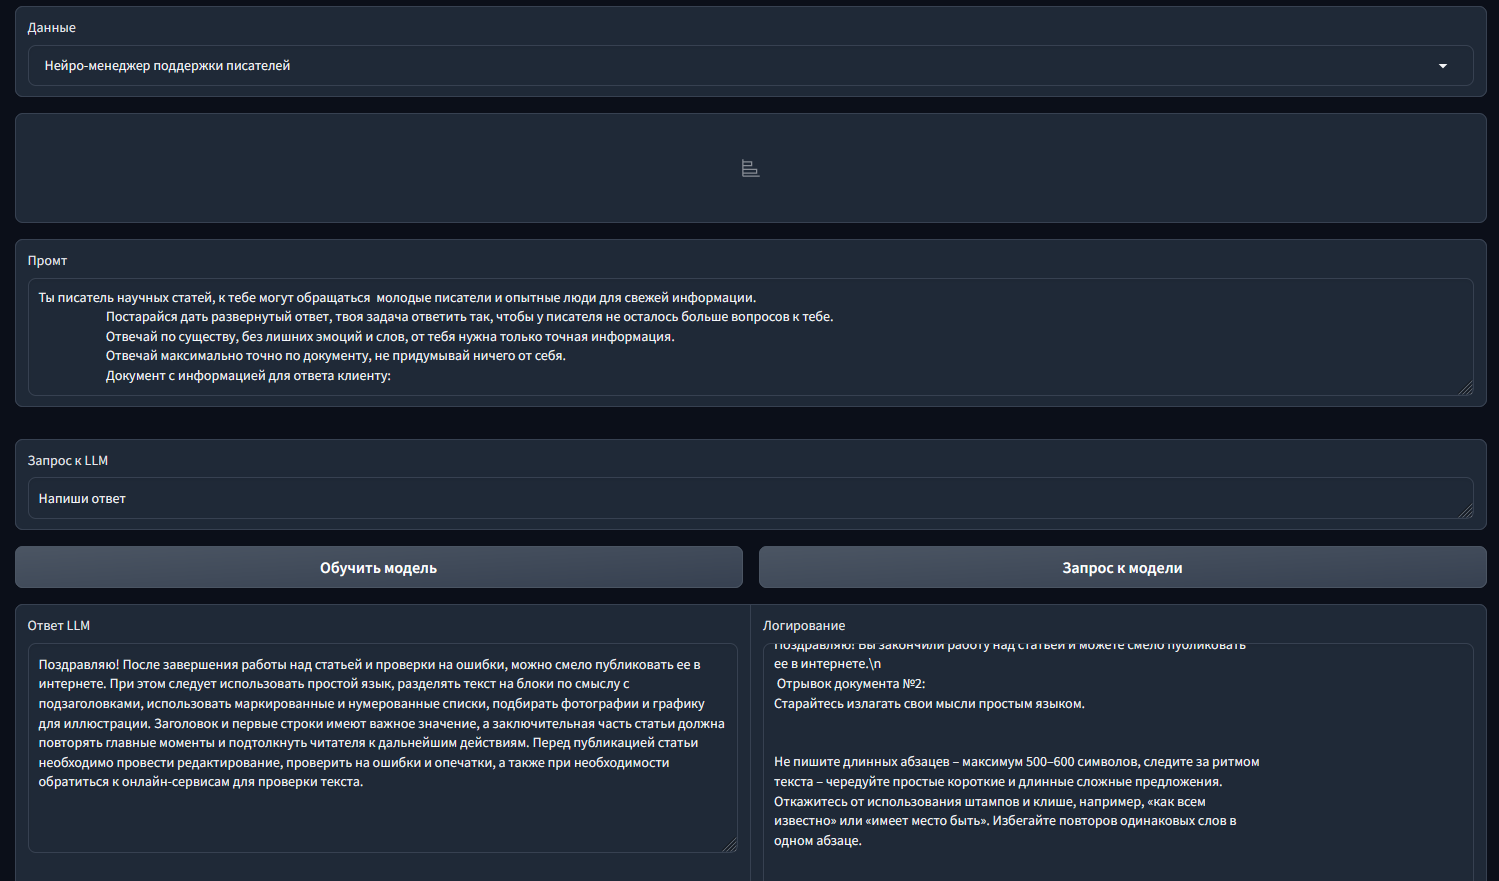